In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from gaia_download import vari_class, vari_short_timescale
import gPhoton
from download_isochrone import load_isochrone
from extinction import add_colors_and_abs_mag
import plotly.graph_objects as go
from simbad_download import fetch_catalog_id
import pyvo as vo
import numpy as np

from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from download_lightcurves import download_dr3_lightcurve

In [7]:
CLUSTER_NAME: str = 'King 11'

In [48]:
bss_candidates = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_bss.csv')
yss_candidates = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_yss.csv')

bss_candidates = add_colors_and_abs_mag(bss_candidates)
yss_candidates = add_colors_and_abs_mag(yss_candidates)

In [49]:
sources = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}.csv')
clustered = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_clustered.csv')
found = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_found.csv')
isochrone = load_isochrone(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_isochrone.dat')

<IPython.core.display.Javascript object>


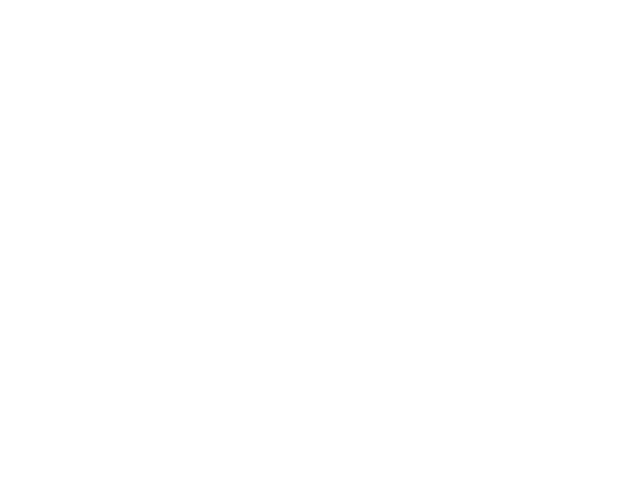

In [50]:
plt.figure()
plt.hist(clustered.parallax_over_error, bins=25);

In [51]:
bss_candidates = bss_candidates[bss_candidates.G_abs_error<=np.quantile(clustered.G_abs_error, [.5])[0]]
yss_candidates = yss_candidates[yss_candidates.G_abs_error<=np.quantile(clustered.G_abs_error, [.5])[0]]

In [52]:
TO_COLOR = np.min(isochrone[:, 0])

In [53]:
%matplotlib notebook

<IPython.core.display.Javascript object>


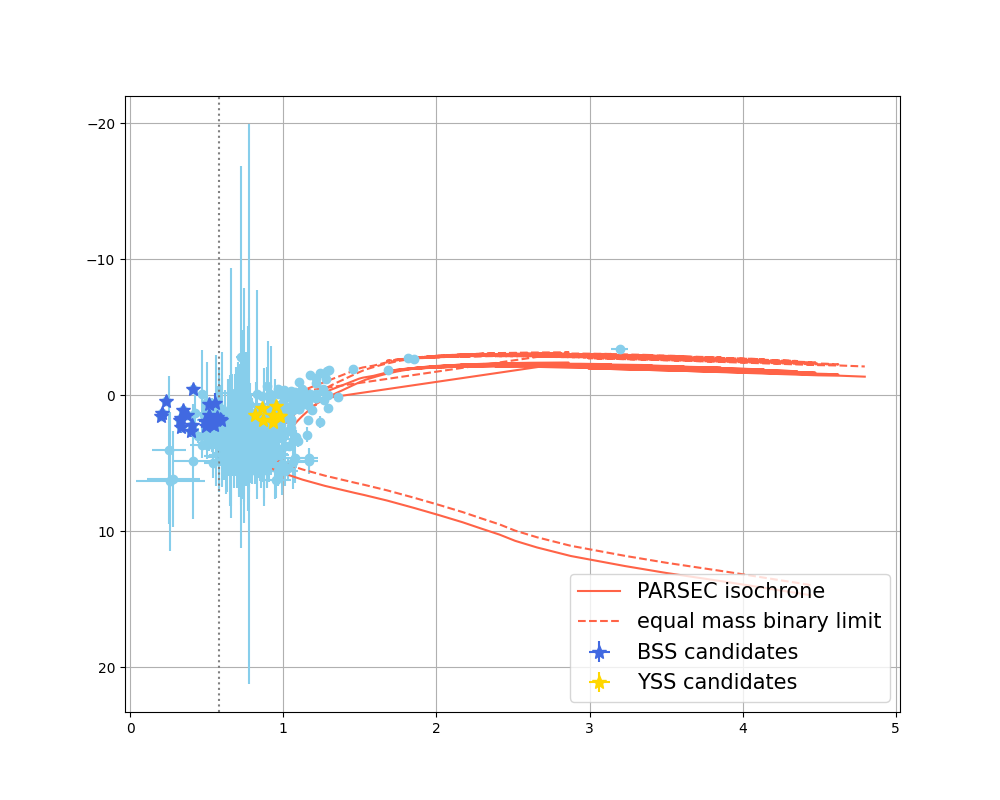

/home/mjablons/.local/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/mjablons/.local/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


In [54]:
plt.figure(figsize=(10, 8))
TO_COLOR = np.min(isochrone[:, 0])
plt.errorbar(clustered['BP-RP'], clustered['G_abs'], color='skyblue', xerr=clustered['BP-RP_error'],
             yerr=clustered['G_abs_error'], fmt='o')
plt.errorbar(bss_candidates['BP-RP'], bss_candidates['G_abs'],
             xerr=bss_candidates['BP-RP_error'], yerr=bss_candidates['G_abs_error'],
             color='royalblue', fmt='*', zorder=2, label='BSS candidates', markersize=10.)
plt.errorbar(yss_candidates['BP-RP'], yss_candidates['G_abs'],
             xerr=yss_candidates['BP-RP_error'], yerr=yss_candidates['G_abs_error'],
             color='gold', fmt='*', zorder=2, label='YSS candidates', markersize=10.)

plt.plot(isochrone[:, 0], isochrone[:, 1], color='tomato', label='PARSEC isochrone')
plt.plot(isochrone[:, 0], isochrone[:, 1]-0.75, color='tomato', label='equal mass binary limit',
         linestyle='--')
plt.axvline(x=TO_COLOR, color='gray', linestyle='dotted')
plt.gca().invert_yaxis();
plt.legend(fontsize=15, loc='lower right');
plt.grid();

In [58]:
from sklearn.preprocessing import StandardScaler
par_over_err = StandardScaler().fit_transform(clustered.parallax_over_error.values.reshape(-1, 1))
#par_over_err = clustered.parallax_over_error.values
normalized_par_over_err = (par_over_err-np.min(par_over_err))/(np.max(par_over_err)-np.min(par_over_err))

In [60]:
isochrone = isochrone[:120]

<IPython.core.display.Javascript object>


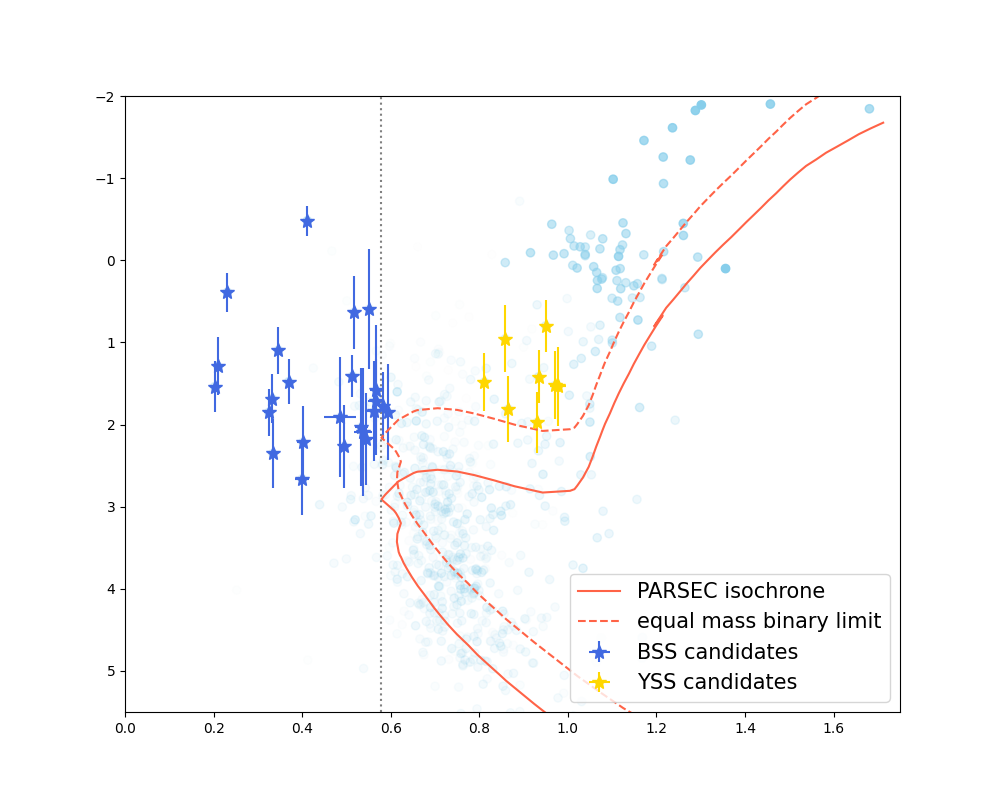

In [62]:
plt.figure(figsize=(10, 8))
TO_COLOR = np.min(isochrone[:, 0])
plt.scatter(clustered['BP-RP'], clustered['G_abs'], color='skyblue', alpha=normalized_par_over_err)
plt.errorbar(bss_candidates['BP-RP'], bss_candidates['G_abs'],
             xerr=bss_candidates['BP-RP_error'], yerr=bss_candidates['G_abs_error'],
             color='royalblue', fmt='*', zorder=2, label='BSS candidates', markersize=10.)
plt.errorbar(yss_candidates['BP-RP'], yss_candidates['G_abs'],
             xerr=yss_candidates['BP-RP_error'], yerr=yss_candidates['G_abs_error'],
             color='gold', fmt='*', zorder=2, label='YSS candidates', markersize=10.)

plt.plot(isochrone[:, 0], isochrone[:, 1], color='tomato', label='PARSEC isochrone')
plt.plot(isochrone[:, 0], isochrone[:, 1]-0.75, color='tomato', label='equal mass binary limit',
         linestyle='--')
plt.axvline(x=TO_COLOR, color='gray', linestyle='dotted')
plt.gca().invert_yaxis();
plt.legend(fontsize=15, loc='lower right');
plt.gca().set_xlim(0, 1.75);
plt.gca().set_ylim(5.5, -2.);

# BSS variability

In [63]:
bss_candidates = add_colors_and_abs_mag(bss_candidates).drop_duplicates(subset=['source_id'])

In [64]:
bss_candidates.head()

,Unnamed: 0.1,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,...,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences,outlier
0,1,9651,1636148068921376768,Gaia DR3 2214223179172287744,2214223179172287744,446813392,2016.0,-3.094110,0.038180,68.717080,...,1.410283,0.909918,0.332349,0.005824,1.684021,0.293660,0.123704,0,0.90,-1
1,2,42128,1636148068921376768,Gaia DR3 2211125275102450816,2211125275102450816,1468023234,2016.0,-3.127598,0.030110,68.598812,...,1.264893,0.816112,0.346440,0.004239,1.094914,0.286305,0.111937,0,0.90,-1
2,3,42150,1636148068921376768,Gaia DR3 2211125378181994112,2211125378181994112,913773861,2016.0,-3.250037,0.060405,68.593959,...,1.395744,0.900538,0.567210,0.013301,1.577995,0.791704,0.134044,0,0.35,1
3,4,42174,1636148068921376768,Gaia DR3 2211125476959735680,2211125476959735680,460212261,2016.0,-3.101076,0.048254,68.615038,...,1.395744,0.900538,0.583240,0.008098,1.772845,0.416810,0.134613,0,0.80,1
4,7,42390,1636148068921376768,Gaia DR3 2211126301593476864,2211126301593476864,8682490,2016.0,-3.111000,0.055656,68.631937,...,1.374712,0.886968,0.333672,0.009234,2.351953,0.416721,0.102567,0,0.75,-1


In [65]:
bss_var = bss_candidates[bss_candidates.phot_variable_flag=='VARIABLE']

In [68]:
bss_var

,Unnamed: 0.1,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,...,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences,outlier
21,62,41672,1636148068921376768,Gaia DR3 2211122217085752704,2211122217085752704,1519358746,2016.0,-3.148045,0.044406,68.561474,...,1.264893,0.816112,0.566417,0.017684,1.708331,0.502783,0.12062,0,0.1,1


In [75]:
bss_var.parallax_over_error

21    4.319012
Name: parallax_over_error, dtype: float64

In [69]:
vari_class(bss_var.source_id.values)

INFO: Query finished. [astroquery.utils.tap.core]


,source_id,in_vari_rrlyrae,in_vari_cepheid,in_vari_planetary_transit,in_vari_short_timescale,in_vari_long_period_variable,in_vari_eclipsing_binary,in_vari_rotation_modulation,in_vari_ms_oscillator,in_vari_agn,in_vari_microlensing,in_vari_compact_companion
0,2211122217085752704,false,false,false,false,false,true,false,false,false,false,false


In [70]:
bss_candidates[bss_candidates.ruwe>1.4][['source_id', 'has_epoch_photometry', 'ruwe', 'excess', 'occurences']]

,source_id,has_epoch_photometry,ruwe,excess,occurences


In [71]:
np.any(bss_candidates.has_epoch_rv)

False

In [72]:
bss_rv_amplitude = bss_candidates.dropna(subset=['rv_amplitude_robust'])
bss_rv_amplitude[['source_id', 'radial_velocity', 'rv_amplitude_robust', 'radial_velocity_error']]

,source_id,radial_velocity,rv_amplitude_robust,radial_velocity_error


In [76]:
np.abs(bss_rv_amplitude.rv_amplitude_robust)>=6*bss_rv_amplitude.radial_velocity_error

Series([], dtype: bool)

In [77]:
bss_rv_amplitude.parallax_over_error

Series([], Name: parallax_over_error, dtype: float64)

In [78]:
bss_candidates.non_single_star

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
Name: non_single_star, dtype: int64

In [79]:
bss_rv_amplitude.G_abs

Series([], Name: G_abs, dtype: float64)

In [80]:
bss_rv_amplitude['BP-RP']

Series([], Name: BP-RP, dtype: float64)

In [81]:
for _, bss in bss_var.iterrows():
    print(f'{bss.source_id}: {bss.ra}, {bss.dec}:')
    gPhoton.gFind(skypos=[bss.ra, bss.dec])
    print()

2211122217085752704: -3.1480445533701413, 68.56147423035965:
NUV: 97.0s (raw) in 1 exposures.
    [ 1004722973.995, 1004723070.995 ], 97.000 seconds
No FUV exposure time in database.



# YSS variability

In [82]:
yss_var = yss_candidates[yss_candidates.phot_variable_flag=='VARIABLE'].drop_duplicates(subset=['source_id'])

In [83]:
yss_var

,Unnamed: 0.1,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,...,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences,outlier


In [84]:
yss_var.has_epoch_photometry

Series([], Name: has_epoch_photometry, dtype: bool)

In [85]:
for _, bss in yss_var.iterrows():
    print(f'{bss.source_id}: {bss.ra}, {bss.dec}:')
    gPhoton.gFind(skypos=[bss.ra, bss.dec])
    print()

In [86]:
yss_candidates.non_single_star

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
Name: non_single_star, dtype: int64

In [87]:
yss_candidates.ruwe

0    0.927356
1    1.367425
2    1.007284
3    0.972425
4    0.954597
5    1.020474
6    1.056778
7    0.978792
Name: ruwe, dtype: float64

In [88]:
yss_rv_amplitude = yss_candidates.dropna(subset=['rv_amplitude_robust'])
yss_rv_amplitude[['source_id', 'rv_amplitude_robust', 'radial_velocity_error', 'occurences']]

,source_id,rv_amplitude_robust,radial_velocity_error,occurences


In [89]:
np.abs(yss_rv_amplitude.rv_amplitude_robust)>=6*yss_rv_amplitude.radial_velocity_error

Series([], dtype: bool)

In [94]:
bss_candidates.occurences.value_counts()

0.80    4
0.90    3
0.05    3
0.35    2
0.60    2
0.30    2
0.75    1
0.95    1
0.50    1
0.70    1
0.45    1
0.65    1
0.55    1
0.10    1
Name: occurences, dtype: int64

In [95]:
len(bss_candidates)

24

In [96]:
len(yss_candidates)

8

In [97]:
yss_candidates.occurences.value_counts()

0.75    2
0.95    2
0.45    1
0.85    1
0.30    1
0.65    1
Name: occurences, dtype: int64

In [98]:
len(bss_candidates.drop_duplicates(subset=['source_id']))

24

In [99]:
len(yss_candidates)

8

In [100]:
bss_candidates.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_bss.csv')
yss_candidates.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_yss.csv')